In [2]:
%pylab inline
import gc
import galsim
import numpy as np
import astropy.io.fits as pyfits

import fpfsBase

Populating the interactive namespace from numpy and matplotlib


In [3]:
cd wrkDir/FPFS2/sim

/lustre/work/xiangchong.li/work/FPFS2/sim


+ corrections for ellipticity, response and flux ratio 

$\frac{x}{1+x}=x-x^2$

$\frac{y}{1+x}=y(1-x)$

$\frac{a}{1+x}=a(1-x+x^2)$

$\frac{a^2}{(1+x)^2}=a^2(1-2x+3x^2)$

$\frac{(a+y)^2}{(1+x)^2}=a^2(1-2x+3x^2)+y^2+2ay(1-2x)$

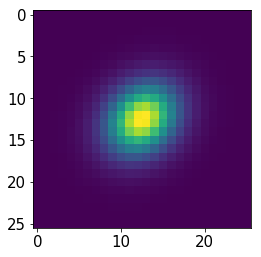

In [3]:
ngrid=64
nx=100;ny=100
ngal=nx*ny
psfFWHM=0.60
scale=0.168
igal=89
beta=0.75

hsmCat=pyfits.getdata('sim20210301/galaxy_basic_psf%d/hsm-0-g1-2222.fits' %(psfFWHM*100))
rcutArray=np.maximum(np.minimum(np.int_(hsmCat['regauss_detR']*5),15),11)
rcut=rcutArray[igal]
    
beg=ngrid//2-rcut
end=beg+2*rcut
galImgAll=pyfits.getdata('sim20210301/galaxy_basic_psf%d/image-0-g1-2222.fits' %(psfFWHM*100))
img=galImgAll[igal//nx*ngrid+beg:igal//nx*ngrid+end,igal%nx*ngrid+beg:igal%nx*ngrid+end]/10.
plt.imshow(img)

In [4]:
# Initialize the fpfsTask
psfInt  =   galsim.Moffat(beta=3.5,fwhm=psfFWHM,trunc=psfFWHM*4.)
psfInt  =   psfInt.shear(e1=0.02,e2=-0.02)
psfImg  =   psfInt.drawImage(nx=64,ny=64,scale=scale)
psfData =   psfImg.array[beg:end,beg:end]
fpTask0=fpfsBase.fpfsTask(psfData,beta=beta)

a0=fpTask0.measure(img)
C=12
b0=fpfsBase.fpfsM2E(a0,C)
print(a0,a0.dtype.names)
print(b0,b0.dtype.names)

(505.61906161, 1.57699595, 60.39571237, 25.30104185) ('fpfs_M00', 'fpfs_M22c', 'fpfs_M22s', 'fpfs_M40')
[(0.00304663, 0.11667985, 0.66578398, 0.97681693)] ('fpfs_e1', 'fpfs_e2', 'fpfs_RE', 'fpfs_s0')


In [5]:
b0.shape

(1,)

In [ ]:
# Noise
corPre      =   'corPre'
corFname    =   os.path.join(corPre,'correlation.fits')
variance    =   1e-3
ngrid=64

if False:
    corIn=pyfits.getdata(corFname)*variance
    corIn=np.pad(corIn,(23-32+rcut,22-32+rcut))

    corNum=np.fft.fftshift(np.fft.ifft2(np.abs(np.fft.fft2(np.ones(img.shape)))**2.)).real
    corIn=corIn*corNum
    powIn=np.fft.fftshift(np.fft.fft2(np.fft.fftshift(corIn)).real)
else:
    powIn=np.load('corPre/noiPows2.npy',allow_pickle=True).item()['%s'%rcut]*variance
powModel=np.zeros((1,img.shape[0],img.shape[1]))
powModel[0]=powIn
#fpTask=fpfsBase.fpfsTask(psfData,noiModel=powModel)
fpTask=fpfsBase.fpfsTask(psfData,noiFit=powModel[0],beta=beta)

In [7]:
%%time
a=[]
for j in range(0,1):
    noiAll=pyfits.getdata('sim20210301/noise/noi%04d.fits' %j)*np.sqrt(variance*100.)
    imgList=[noiAll[i//nx*ngrid+beg:i//nx*ngrid+end,i%nx*ngrid+beg:i%nx*ngrid+end]+img for i in range(ngal)]
    #plt.imshow(imgList[5])
    res=fpTask.measure(imgList)
    a.append(res)
    del noiAll,imgList
    gc.collect()
a=np.vstack(a)

(10000,)
CPU times: user 5.2 s, sys: 501 ms, total: 5.7 s
Wall time: 5.7 s


In [9]:
print('variance of N00 from simulation and equation:')
print(np.var(a['fpfs_M00']),np.average(a['fpfs_N00N00']))
print('variance of N40 from simulation and equation:')
print(np.var(a['fpfs_M40']),np.average(a['fpfs_N40N40']))
print('variance of N22c from simulation and equation:')
print(np.var(a['fpfs_M22c']),np.average(a['fpfs_N22cN22c']))
print('variance of N22s from simulation and equation:')
print(np.var(a['fpfs_M22s']),np.average(a['fpfs_N22sN22s']))
print('cov of N22cN00 from simulation and equation:')
print(np.average(a['fpfs_M22c']*a['fpfs_M00'])-np.average(a['fpfs_M22c'])*np.average(a['fpfs_M00']),np.average(a['fpfs_N00N22c']))
print('cov of N22cN00 from simulation and equation:')
print(np.average(a['fpfs_M22s']*a['fpfs_M00'])-np.average(a['fpfs_M22s'])*np.average(a['fpfs_M00']),np.average(a['fpfs_N00N22s']))
print('cov of N40N00 from simulation and equation:')
print(np.average(a['fpfs_M40']*a['fpfs_M00'])-np.average(a['fpfs_M40'])*np.average(a['fpfs_M00']),np.average(a['fpfs_N00N40']))

variance of N00 from simulation and equation:
601.6288327641689 626.4506708474111
variance of N40 from simulation and equation:
743.1694004113376 731.0780029821453
variance of N22c from simulation and equation:
356.7574288140035 337.1824728612719
variance of N22s from simulation and equation:
346.1897241105808 343.15672575728115
cov of N22cN00 from simulation and equation:
0.19689186979474016 5.677581223871431
cov of N22cN00 from simulation and equation:
55.71184210663341 59.356435941833396
cov of N40N00 from simulation and equation:
-106.58991858266927 -62.158890584129374


In [10]:
%%time
b=fpfsBase.fpfsM2E(a,C)

CPU times: user 0 ns, sys: 1.16 ms, total: 1.16 ms
Wall time: 725 µs


In [11]:
print('Discrepancy in ellipticities and Response')
print('e1:',np.average(b['fpfs_e1'])-np.average(b0['fpfs_e1']),np.average(b['fpfs_e1'])/np.average(b0['fpfs_e1'])-1)
print('e2:',np.average(b['fpfs_e2'])-np.average(b0['fpfs_e2']),np.average(b['fpfs_e2'])/np.average(b0['fpfs_e2'])-1)
print('esq1:',np.average(b['fpfs_e1']**2.)-np.average(b0['fpfs_e1']**2.),np.average(b['fpfs_e1']**2.)/np.average(b0['fpfs_e1']**2.)-1)
print('esq2:',np.average(b['fpfs_e2']**2.)-np.average(b0['fpfs_e2']**2.),np.average(b['fpfs_e2']**2.)/np.average(b0['fpfs_e2']**2.)-1)
print('s0:',np.average(a['fpfs_M00']/(a['fpfs_M00']+C))-np.average(a0['fpfs_M00']/(a0['fpfs_M00']+C)))
print('s4:',np.average(a['fpfs_M40']/(a['fpfs_M00']+C))-np.average(a0['fpfs_M40']/(a0['fpfs_M00']+C)))
print('RE:',np.average(b['fpfs_RE'])-np.average(b0['fpfs_RE']),np.average(b['fpfs_RE'])/np.average(b0['fpfs_RE'])-1)

Discrepancy in ellipticities and Response
e1: 0.0003054423058776283 0.10025565340204357
e2: -9.515566575080125e-06 -8.155278658283915e-05
esq1: 0.0013330415140436743 143.6160701759741
esq2: 0.0012752368475651647 0.09366970639167027
s0: -6.094939470735472e-05
s4: 0.0011485406870575393
RE: 0.0009890926781219722 0.0014856059947789824


In [12]:
# e
ratio=a['fpfs_N00N00']/(a['fpfs_M00']+C)**2.
e1=np.average((b['fpfs_e1']+a['fpfs_N00N22c']/(a['fpfs_M00']+C)**2.)/(1+ratio))
e2=np.average((b['fpfs_e2']+a['fpfs_N00N22s']/(a['fpfs_M00']+C)**2.)/(1+ratio))
print(e1-np.average(b0['fpfs_e1']),e1/np.average(b0['fpfs_e1'])-1)
print(e2-np.average(b0['fpfs_e2']),e2/np.average(b0['fpfs_e2'])-1)

0.0003187367866051825 0.1046193149719501
-6.0634836701420336e-05 -0.0005196684672404972


In [13]:
e1sq=np.average((b['fpfs_e1']**2.-a['fpfs_N22cN22c']/(a['fpfs_M00']+C)**2.+4.*b['fpfs_e1']*a['fpfs_N00N22c']/(a['fpfs_M00']+C)**2.)/(1.+3*ratio))
e2sq=np.average((b['fpfs_e2']**2.-a['fpfs_N22sN22s']/(a['fpfs_M00']+C)**2.+4.*b['fpfs_e2']*a['fpfs_N00N22s']/(a['fpfs_M00']+C)**2.)/(1.+3*ratio))
print(e1sq-np.average(b0['fpfs_e1']**2.),e1sq/np.average(b0['fpfs_e1']**2.)-1)
print(e2sq-np.average(b0['fpfs_e2']**2.),e2sq/np.average(b0['fpfs_e2']**2.)-1)

8.28218280495194e-05 8.922861999384468
9.157371207529214e-06 0.0006726344788159366


In [14]:
#s0 s4
s0=np.average((a['fpfs_M00']/(a['fpfs_M00']+C)+a['fpfs_N00N00']/(a['fpfs_M00']+C)**2.)/(1+ratio))
s4=np.average((a['fpfs_M40']/(a['fpfs_M00']+C)+a['fpfs_N00N40']/(a['fpfs_M00']+C)**2.)/(1+ratio))
RE=(s0-s4+e1sq+e2sq)/np.sqrt(2.)
print(s0-np.average(a0['fpfs_M00']/(a0['fpfs_M00']+C)))
print(s4-np.average(a0['fpfs_M40']/(a0['fpfs_M00']+C)))
print(RE-np.average(b0['fpfs_RE']))

-6.465727351745443e-06
0.0008006943198874822
-0.0005057092273829111


In [15]:
print(e1/RE-np.average(b0['fpfs_e1'])/np.average(b0['fpfs_RE']))
print(e2/RE-np.average(b0['fpfs_e2'])/np.average(b0['fpfs_RE']))

0.0004825813937189465
4.207505340431128e-05


In [16]:
np.average(b['fpfs_e1'])/np.average(b['fpfs_RE'])-np.average(b0['fpfs_e1'])/np.average(b0['fpfs_RE'])

0.00045130227695113195

In [17]:
np.average(b['fpfs_e2'])/np.average(b['fpfs_RE'])-np.average(b0['fpfs_e2'])/np.average(b0['fpfs_RE'])

-0.00027423999488246364

In [18]:
a.dtype.names

('fpfs_M00',
 'fpfs_M22c',
 'fpfs_M22s',
 'fpfs_M40',
 'fpfs_N00N00',
 'fpfs_N22cN22c',
 'fpfs_N22sN22s',
 'fpfs_N40N40',
 'fpfs_N00N22c',
 'fpfs_N00N22s',
 'fpfs_N00N40')

In [20]:
def fpfsM2E(moments,const=1.,mcalib=0.,rev=False):
    """
    # Estimate FPFS ellipticities from fpfs moments

    Parameters:
    -----------
    moments:    input FPFS moments     [float array]
    const:      the weighting Constant [float]
    mcalib:     multiplicative bias [float array]

    Returns:
    -------------
    out :       an array of FPFS ellipticities,
                FPFS ellipticity response,
                FPFS flux ratio, and FPFS selection response
    """
    #Get weight
    weight  =   moments['fpfs_M00']+const
    #Ellipticity
    e1      =   moments['fpfs_M22c']/weight
    e2      =   moments['fpfs_M22s']/weight
    e1sq    =   e1*e1
    e2sq    =   e2*e2
    #FPFS flux ratio
    s0      =   moments['fpfs_M00']/weight
    s4      =   moments['fpfs_M40']/weight

    if rev:
        assert 'fpfs_N00N00' in moments.dtype.names
        assert 'fpfs_N00N22c' in moments.dtype.names
        assert 'fpfs_N00N22s' in moments.dtype.names
        ratio=  moments['fpfs_N00N00']/weight**2.
        e1  =   (e1+moments['fpfs_N00N22c']\
                /weight**2.)/(1+ratio)
        e2  =   (e2+moments['fpfs_N00N22s']\
                /weight**2.)/(1+ratio)
        e1sq=   (e1sq-moments['fpfs_N22cN22c']/weight**2.\
                +4.*e1*moments['fpfs_N00N22c']/weight**2.)\
                /(1.+3*ratio)
        e2sq=   (e2sq-moments['fpfs_N22sN22s']/weight**2.\
                +4.*e2*moments['fpfs_N00N22s']/weight**2.)\
                /(1.+3*ratio)
        s0  =   (s0+moments['fpfs_N00N00']\
                /weight**2.)/(1+ratio)
        s4  =   (s4+moments['fpfs_N00N40']\
                /weight**2.)/(1+ratio)

    #Response factor
    RE      =   1./np.sqrt(2.)*(s0-s4+e1sq+e2sq)
    types   =   [('fpfs_e1','>f8'),('fpfs_e2','>f8'),('fpfs_RE','>f8'),('fpfs_s0','>f8')]
    ellDat  =   np.array(np.zeros(moments.size),dtype=types)
    ellDat['fpfs_e1']=e1
    ellDat['fpfs_e2']=e2
    ellDat['fpfs_RE']=RE
    ellDat['fpfs_s0']=s0
    return ellDat

b2=fpfsM2E(a,C,rev=True)

In [21]:
print(np.average(b2['fpfs_e1']-b0['fpfs_e1']))
print(np.average(b2['fpfs_e2']-b0['fpfs_e2']))
print(np.average(b2['fpfs_RE']-b0['fpfs_RE']))
print(np.average(b2['fpfs_s0']-b0['fpfs_s0']))
print(np.average(b2['fpfs_e1'])/np.average(b2['fpfs_RE'])-np.average(b0['fpfs_e1'])/np.average(b0['fpfs_RE']))
print(np.average(b2['fpfs_e2'])/np.average(b2['fpfs_RE'])-np.average(b0['fpfs_e2'])/np.average(b0['fpfs_RE']))

0.0003187367866051827
-6.063483670141656e-05
-0.0005057408135595503
-6.465727351738515e-06
0.0004825816338914846
4.208337603256451e-05


In [22]:
print(np.average(b['fpfs_e1']-b0['fpfs_e1']))
print(np.average(b['fpfs_e2']-b0['fpfs_e2']))
print(np.average(b['fpfs_RE']-b0['fpfs_RE']))
print(np.average(b['fpfs_s0']-b0['fpfs_s0']))
print(np.average(b['fpfs_e1'])/np.average(b['fpfs_RE'])-np.average(b0['fpfs_e1'])/np.average(b0['fpfs_RE']))
print(np.average(b['fpfs_e2'])/np.average(b['fpfs_RE'])-np.average(b0['fpfs_e2'])/np.average(b0['fpfs_RE']))

0.0003054423058776284
-9.515566575081147e-06
0.000989092678122004
-6.094939470732178e-05
0.00045130227695113195
-0.00027423999488246364
